<a href="https://colab.research.google.com/github/seenu-g/school_of_ai/blob/master/chap5/Iteration3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Iteration1 - Setup
**Target**
Reduced the dropout from 0.12 to 0.05
Set bias = true in convolution
**Results**
Parameters : 9968
Best training accuracy : 99.10
Best test accuracy : 99.33
**Analysis**
Coming close to  the desired accuracy earlier to 15th epoch 
and it increase number of parameters




In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       #transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [12]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


**Model**

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_layer1 = nn.Sequential(                      
            nn.Conv2d(in_channels=1, out_channels=12, kernel_size=(3, 3), padding=0, bias=True),#Op_size = 26, RF = 3
            nn.ReLU(),
            nn.BatchNorm2d(num_features=12),
            nn.Dropout2d(0.05)
        )
        self.conv_layer2 = nn.Sequential(  
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=True),#Op_size = 24, RF = 5
            nn.ReLU(),
            nn.BatchNorm2d(num_features=12),
            nn.Dropout2d(0.05)
        )
        self.maxpool_layer1 = nn.MaxPool2d(kernel_size=(2,2)) #Op_size = 12, RF = 6
        self.conv_layer3 = nn.Sequential(  
            nn.Conv2d(in_channels=12, out_channels=14, kernel_size=(3, 3), padding=0, bias=True), #Op_size = 10, RF = 10   
            nn.ReLU(),
            nn.BatchNorm2d(num_features=14),
            nn.Dropout2d(0.05)
        )
        self.conv_layer4 = nn.Sequential(  
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=True), #Op_size = 8, RF = 14
            nn.ReLU(),
            nn.BatchNorm2d(num_features=16),
            nn.Dropout2d(0.05) 
        )
        self.conv_layer5 = nn.Sequential(  
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=True),#Op_size = 6, RF = 18 
            nn.ReLU(),
            nn.BatchNorm2d(num_features=16),
            nn.Dropout(0.05)
        )
        self.conv_layer6 = nn.Sequential(  
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=True),#Op_size = 6, RF = 22 
            nn.ReLU(),
            nn.BatchNorm2d(num_features=16),
            nn.Dropout(0.05)
        )            
        self.avgpool_layer1 = nn.AvgPool2d(kernel_size=6)

        self.conv_layer7 = nn.Sequential(  
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=True)#Op_size = 1, RF = 28
        )

    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x =  self.maxpool_layer1(x)
        x = self.conv_layer3(x)
        x = self.conv_layer4(x)
        x = self.conv_layer5(x)
        x = self.conv_layer6(x)
        x = self.avgpool_layer1(x)
        x = self.conv_layer7(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

*italicized text*# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [31]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1,28,28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             120
              ReLU-2           [-1, 12, 26, 26]               0
       BatchNorm2d-3           [-1, 12, 26, 26]              24
         Dropout2d-4           [-1, 12, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]           1,308
              ReLU-6           [-1, 12, 24, 24]               0
       BatchNorm2d-7           [-1, 12, 24, 24]              24
         Dropout2d-8           [-1, 12, 24, 24]               0
         MaxPool2d-9           [-1, 12, 12, 12]               0
           Conv2d-10           [-1, 14, 10, 10]           1,526
             ReLU-11           [-1, 14, 10, 10]               0
      BatchNorm2d-12           [-1, 14, 10, 10]              28
        Dropout2d-13           [-1, 14, 10, 10]               0
           Conv2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [32]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.12260692566633224 Batch_id=468 Accuracy=86.53: 100%|██████████| 469/469 [00:12<00:00, 38.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0743, Accuracy: 9807/10000 (98.07%)

EPOCH: 1


Loss=0.048367056995630264 Batch_id=468 Accuracy=97.44: 100%|██████████| 469/469 [00:11<00:00, 40.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0417, Accuracy: 9879/10000 (98.79%)

EPOCH: 2


Loss=0.1309712678194046 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:12<00:00, 37.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0355, Accuracy: 9893/10000 (98.93%)

EPOCH: 3


Loss=0.09226790815591812 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:12<00:00, 38.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 9904/10000 (99.04%)

EPOCH: 4


Loss=0.01888214983046055 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:11<00:00, 39.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9920/10000 (99.20%)

EPOCH: 5


Loss=0.0449029915034771 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:11<00:00, 39.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9920/10000 (99.20%)

EPOCH: 6


Loss=0.04532821476459503 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:12<00:00, 38.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9926/10000 (99.26%)

EPOCH: 7


Loss=0.059099018573760986 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:12<00:00, 38.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9923/10000 (99.23%)

EPOCH: 8


Loss=0.010418151505291462 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:11<00:00, 40.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9939/10000 (99.39%)

EPOCH: 9


Loss=0.0723247155547142 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:11<00:00, 40.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9937/10000 (99.37%)

EPOCH: 10


Loss=0.05396157503128052 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:11<00:00, 40.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9937/10000 (99.37%)

EPOCH: 11


Loss=0.02139587141573429 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:12<00:00, 38.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9927/10000 (99.27%)

EPOCH: 12


Loss=0.019139250740408897 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:11<00:00, 40.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9930/10000 (99.30%)

EPOCH: 13


Loss=0.037390898913145065 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:11<00:00, 44.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9934/10000 (99.34%)

EPOCH: 14


Loss=0.007131064776331186 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:11<00:00, 40.41it/s]



Test set: Average loss: 0.0200, Accuracy: 9933/10000 (99.33%)



Text(0.5, 1.0, 'Test Accuracy')

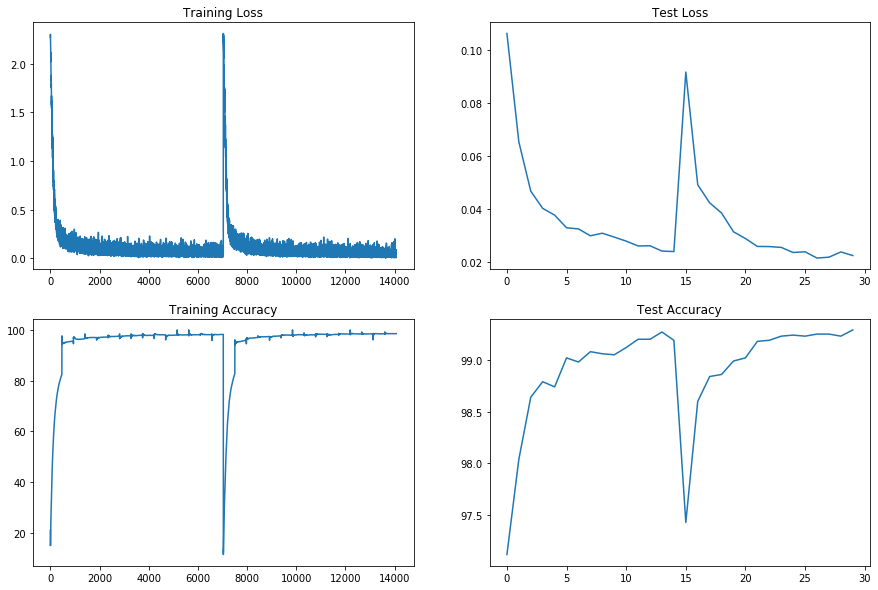

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")